# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed-celeba-small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

/home/manuel/anaconda3/envs/dl-course/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


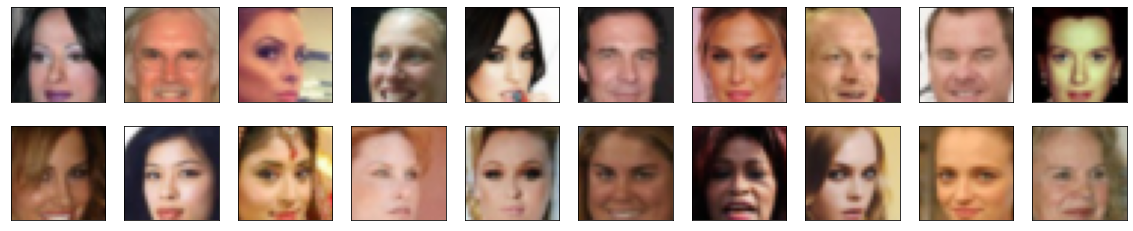

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.7647)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.main = nn.Sequential(
            # input is 3 x 32 x 32
            nn.Conv2d(
                in_channels=3, 
                out_channels=conv_dim, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim) x 16 x 16
            nn.Conv2d(
                in_channels=conv_dim, 
                out_channels=conv_dim * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*2) x 8 x 8
            nn.Conv2d(
                in_channels=conv_dim * 2, 
                out_channels=conv_dim * 4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
            ),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*4) x 4 x 4
            nn.Conv2d(
                in_channels=conv_dim * 4, 
                out_channels=1, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            )
        )

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        return self.main(x).reshape(-1,1)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_size, conv_dim*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim*4),
            nn.ReLU(True),
            # state size. (conv_dim*8) x 4 x 4
            nn.ConvTranspose2d(conv_dim * 4, conv_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim*2),
            nn.ReLU(True),
            # state size. (conv_dim*4) x 8 x 8
            nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            # state size. (conv_dim) x 16 x 16
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x=x.reshape(x.shape[0],x.shape[1],1,1)
        return self.main(x)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
criterion = nn.BCEWithLogitsLoss()
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
     
    if train_on_gpu:
        labels = labels.cuda()
        
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

lr = 0.002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            ## Reset gradient
            d_optimizer.zero_grad()
            
            ## Get real batch
            if train_on_gpu:
                real_images = real_images.cuda()
            ## Forward pass real batch through D
            d_real_out = D(real_images)
            ## Compute real loss
            d_real_loss = real_loss(d_real_out)
            
            ## Get fake batch
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            ## Forward pass fake batch through D
            d_fake_out = D(fake_images)
            ## Compute fake loss
            d_fake_loss = fake_loss(d_fake_out)
            
            ## Compute total loss
            d_loss = d_real_loss + d_fake_loss
            ## Backprop
            d_loss.backward()
            ## Optimization Step
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            ## Train with fake images and flipped labels
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake) # using real loss to flip labels
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.6122 | g_loss: 12.7551
Epoch [    1/   30] | d_loss: 1.0480 | g_loss: 1.7406
Epoch [    1/   30] | d_loss: 2.0339 | g_loss: 1.5683
Epoch [    1/   30] | d_loss: 2.1053 | g_loss: 1.1134
Epoch [    1/   30] | d_loss: 1.4190 | g_loss: 1.7739
Epoch [    1/   30] | d_loss: 1.0346 | g_loss: 1.0810
Epoch [    1/   30] | d_loss: 0.8030 | g_loss: 1.5153
Epoch [    1/   30] | d_loss: 1.2783 | g_loss: 4.1670
Epoch [    1/   30] | d_loss: 1.6397 | g_loss: 1.3466
Epoch [    1/   30] | d_loss: 0.9146 | g_loss: 2.7697
Epoch [    1/   30] | d_loss: 1.4690 | g_loss: 1.8175
Epoch [    1/   30] | d_loss: 0.7591 | g_loss: 2.2171
Epoch [    1/   30] | d_loss: 1.2411 | g_loss: 2.6527
Epoch [    1/   30] | d_loss: 2.1183 | g_loss: 4.7021
Epoch [    1/   30] | d_loss: 1.1695 | g_loss: 2.2278
Epoch [    1/   30] | d_loss: 1.1829 | g_loss: 1.9010
Epoch [    1/   30] | d_loss: 0.8330 | g_loss: 1.8957
Epoch [    1/   30] | d_loss: 1.1395 | g_loss: 2.1634
Epoch [    1/   30] | d_los

Epoch [    3/   30] | d_loss: 1.2728 | g_loss: 1.2491
Epoch [    3/   30] | d_loss: 1.4522 | g_loss: 0.6310
Epoch [    3/   30] | d_loss: 1.0059 | g_loss: 1.3365
Epoch [    3/   30] | d_loss: 1.1022 | g_loss: 1.4926
Epoch [    3/   30] | d_loss: 1.3678 | g_loss: 1.8024
Epoch [    3/   30] | d_loss: 1.0774 | g_loss: 1.1778
Epoch [    3/   30] | d_loss: 1.1439 | g_loss: 1.1552
Epoch [    3/   30] | d_loss: 1.2492 | g_loss: 0.7209
Epoch [    3/   30] | d_loss: 1.2316 | g_loss: 1.3913
Epoch [    3/   30] | d_loss: 1.1705 | g_loss: 1.3882
Epoch [    3/   30] | d_loss: 1.2076 | g_loss: 1.3408
Epoch [    3/   30] | d_loss: 1.2202 | g_loss: 1.2746
Epoch [    3/   30] | d_loss: 1.0042 | g_loss: 1.2538
Epoch [    3/   30] | d_loss: 1.3741 | g_loss: 1.7850
Epoch [    3/   30] | d_loss: 1.0914 | g_loss: 1.3188
Epoch [    3/   30] | d_loss: 1.0874 | g_loss: 1.0315
Epoch [    3/   30] | d_loss: 1.1279 | g_loss: 1.9477
Epoch [    3/   30] | d_loss: 1.1634 | g_loss: 1.0484
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.0672 | g_loss: 1.4683
Epoch [    6/   30] | d_loss: 0.6801 | g_loss: 1.6929
Epoch [    6/   30] | d_loss: 1.2153 | g_loss: 1.3205
Epoch [    6/   30] | d_loss: 0.9185 | g_loss: 1.2749
Epoch [    6/   30] | d_loss: 1.5387 | g_loss: 1.8064
Epoch [    6/   30] | d_loss: 1.1061 | g_loss: 0.4302
Epoch [    6/   30] | d_loss: 1.2478 | g_loss: 1.1012
Epoch [    6/   30] | d_loss: 1.3076 | g_loss: 2.0031
Epoch [    6/   30] | d_loss: 0.8665 | g_loss: 1.9638
Epoch [    6/   30] | d_loss: 1.1306 | g_loss: 1.5933
Epoch [    6/   30] | d_loss: 1.0117 | g_loss: 1.0500
Epoch [    6/   30] | d_loss: 1.1163 | g_loss: 1.3536
Epoch [    6/   30] | d_loss: 0.9475 | g_loss: 1.8351
Epoch [    6/   30] | d_loss: 0.8732 | g_loss: 1.3631
Epoch [    6/   30] | d_loss: 1.1043 | g_loss: 2.1566
Epoch [    6/   30] | d_loss: 1.0494 | g_loss: 1.4586
Epoch [    6/   30] | d_loss: 1.0145 | g_loss: 0.9741
Epoch [    6/   30] | d_loss: 0.9051 | g_loss: 1.3010
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 0.6048 | g_loss: 2.2440
Epoch [    9/   30] | d_loss: 0.7573 | g_loss: 1.2391
Epoch [    9/   30] | d_loss: 0.9447 | g_loss: 2.6343
Epoch [    9/   30] | d_loss: 0.6878 | g_loss: 1.7521
Epoch [    9/   30] | d_loss: 0.9710 | g_loss: 2.7278
Epoch [    9/   30] | d_loss: 0.3213 | g_loss: 1.1678
Epoch [    9/   30] | d_loss: 0.9192 | g_loss: 2.4550
Epoch [    9/   30] | d_loss: 0.8074 | g_loss: 2.0523
Epoch [    9/   30] | d_loss: 0.8788 | g_loss: 2.3298
Epoch [    9/   30] | d_loss: 0.7240 | g_loss: 2.2112
Epoch [    9/   30] | d_loss: 1.0289 | g_loss: 1.9692
Epoch [    9/   30] | d_loss: 1.1345 | g_loss: 2.1494
Epoch [    9/   30] | d_loss: 1.0640 | g_loss: 1.5787
Epoch [    9/   30] | d_loss: 1.1104 | g_loss: 1.3781
Epoch [    9/   30] | d_loss: 1.1041 | g_loss: 2.2294
Epoch [    9/   30] | d_loss: 0.5774 | g_loss: 1.8924
Epoch [    9/   30] | d_loss: 0.9973 | g_loss: 1.2880
Epoch [    9/   30] | d_loss: 1.1141 | g_loss: 2.4098
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 1.1066 | g_loss: 1.9136
Epoch [   11/   30] | d_loss: 0.3473 | g_loss: 2.2360
Epoch [   11/   30] | d_loss: 1.2485 | g_loss: 1.0402
Epoch [   11/   30] | d_loss: 1.5460 | g_loss: 2.9091
Epoch [   11/   30] | d_loss: 1.6034 | g_loss: 1.1306
Epoch [   11/   30] | d_loss: 0.9631 | g_loss: 1.8291
Epoch [   11/   30] | d_loss: 1.0269 | g_loss: 0.9543
Epoch [   11/   30] | d_loss: 0.5666 | g_loss: 1.7182
Epoch [   11/   30] | d_loss: 0.7558 | g_loss: 1.5734
Epoch [   11/   30] | d_loss: 0.9934 | g_loss: 2.1317
Epoch [   11/   30] | d_loss: 0.8730 | g_loss: 2.7034
Epoch [   11/   30] | d_loss: 0.6267 | g_loss: 3.5211
Epoch [   11/   30] | d_loss: 1.8004 | g_loss: 2.9882
Epoch [   11/   30] | d_loss: 0.7023 | g_loss: 0.9396
Epoch [   11/   30] | d_loss: 0.7332 | g_loss: 1.5635
Epoch [   11/   30] | d_loss: 1.0739 | g_loss: 2.3231
Epoch [   11/   30] | d_loss: 0.9963 | g_loss: 2.9798
Epoch [   11/   30] | d_loss: 0.6426 | g_loss: 1.2650
Epoch [   12/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.4898 | g_loss: 3.6083
Epoch [   14/   30] | d_loss: 0.4393 | g_loss: 1.3918
Epoch [   14/   30] | d_loss: 1.4510 | g_loss: 1.9834
Epoch [   14/   30] | d_loss: 0.8958 | g_loss: 1.3924
Epoch [   14/   30] | d_loss: 0.9550 | g_loss: 0.5793
Epoch [   14/   30] | d_loss: 0.9445 | g_loss: 2.1264
Epoch [   14/   30] | d_loss: 0.4500 | g_loss: 1.1077
Epoch [   14/   30] | d_loss: 0.7886 | g_loss: 2.5975
Epoch [   14/   30] | d_loss: 0.6329 | g_loss: 2.0713
Epoch [   14/   30] | d_loss: 0.7163 | g_loss: 2.5710
Epoch [   14/   30] | d_loss: 0.6070 | g_loss: 3.0297
Epoch [   14/   30] | d_loss: 0.4364 | g_loss: 1.6323
Epoch [   14/   30] | d_loss: 1.0933 | g_loss: 1.5797
Epoch [   14/   30] | d_loss: 0.8910 | g_loss: 1.8429
Epoch [   14/   30] | d_loss: 0.5664 | g_loss: 4.6131
Epoch [   14/   30] | d_loss: 0.4973 | g_loss: 0.8941
Epoch [   14/   30] | d_loss: 0.8128 | g_loss: 1.9904
Epoch [   14/   30] | d_loss: 0.6087 | g_loss: 1.9994
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.3940 | g_loss: 2.9183
Epoch [   17/   30] | d_loss: 0.2802 | g_loss: 3.3871
Epoch [   17/   30] | d_loss: 0.1563 | g_loss: 3.6661
Epoch [   17/   30] | d_loss: 0.5246 | g_loss: 3.5718
Epoch [   17/   30] | d_loss: 0.2970 | g_loss: 2.6878
Epoch [   17/   30] | d_loss: 0.2994 | g_loss: 3.0137
Epoch [   17/   30] | d_loss: 2.3151 | g_loss: 5.7237
Epoch [   17/   30] | d_loss: 0.7047 | g_loss: 4.4940
Epoch [   17/   30] | d_loss: 0.3325 | g_loss: 3.4574
Epoch [   17/   30] | d_loss: 1.2408 | g_loss: 6.0440
Epoch [   17/   30] | d_loss: 0.9173 | g_loss: 5.2195
Epoch [   17/   30] | d_loss: 0.4292 | g_loss: 4.1745
Epoch [   17/   30] | d_loss: 0.2870 | g_loss: 4.5210
Epoch [   17/   30] | d_loss: 0.6498 | g_loss: 2.0932
Epoch [   17/   30] | d_loss: 0.5042 | g_loss: 3.4366
Epoch [   17/   30] | d_loss: 0.5577 | g_loss: 4.6636
Epoch [   17/   30] | d_loss: 0.7432 | g_loss: 1.8434
Epoch [   17/   30] | d_loss: 0.4586 | g_loss: 3.9580
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.4334 | g_loss: 5.0944
Epoch [   19/   30] | d_loss: 0.6589 | g_loss: 3.1745
Epoch [   19/   30] | d_loss: 0.6042 | g_loss: 3.4312
Epoch [   19/   30] | d_loss: 1.0285 | g_loss: 2.2510
Epoch [   19/   30] | d_loss: 0.4849 | g_loss: 2.2538
Epoch [   19/   30] | d_loss: 0.3830 | g_loss: 4.5897
Epoch [   19/   30] | d_loss: 0.2809 | g_loss: 3.7784
Epoch [   19/   30] | d_loss: 0.4142 | g_loss: 3.4222
Epoch [   19/   30] | d_loss: 0.3465 | g_loss: 2.8884
Epoch [   19/   30] | d_loss: 0.3161 | g_loss: 2.5638
Epoch [   19/   30] | d_loss: 0.7840 | g_loss: 1.5623
Epoch [   19/   30] | d_loss: 0.3437 | g_loss: 3.8756
Epoch [   19/   30] | d_loss: 0.6107 | g_loss: 4.4208
Epoch [   19/   30] | d_loss: 0.7735 | g_loss: 4.2872
Epoch [   19/   30] | d_loss: 0.3802 | g_loss: 2.6814
Epoch [   19/   30] | d_loss: 0.3226 | g_loss: 2.9160
Epoch [   19/   30] | d_loss: 0.8417 | g_loss: 2.6600
Epoch [   19/   30] | d_loss: 0.6764 | g_loss: 3.7088
Epoch [   20/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.5118 | g_loss: 3.4568
Epoch [   22/   30] | d_loss: 0.4754 | g_loss: 2.2134
Epoch [   22/   30] | d_loss: 0.4639 | g_loss: 3.2295
Epoch [   22/   30] | d_loss: 0.3747 | g_loss: 4.2333
Epoch [   22/   30] | d_loss: 0.3944 | g_loss: 2.5722
Epoch [   22/   30] | d_loss: 0.6690 | g_loss: 3.8283
Epoch [   22/   30] | d_loss: 0.5008 | g_loss: 2.9913
Epoch [   22/   30] | d_loss: 0.8692 | g_loss: 3.6231
Epoch [   22/   30] | d_loss: 0.5405 | g_loss: 2.4213
Epoch [   22/   30] | d_loss: 0.4614 | g_loss: 3.2782
Epoch [   22/   30] | d_loss: 0.5708 | g_loss: 4.3860
Epoch [   22/   30] | d_loss: 0.2954 | g_loss: 3.5004
Epoch [   22/   30] | d_loss: 0.3455 | g_loss: 5.9268
Epoch [   22/   30] | d_loss: 0.3580 | g_loss: 1.8109
Epoch [   22/   30] | d_loss: 0.2446 | g_loss: 3.4738
Epoch [   22/   30] | d_loss: 0.1793 | g_loss: 4.1807
Epoch [   22/   30] | d_loss: 0.3541 | g_loss: 3.4211
Epoch [   22/   30] | d_loss: 0.6846 | g_loss: 2.6120
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 1.1944 | g_loss: 4.9401
Epoch [   25/   30] | d_loss: 0.8249 | g_loss: 3.4942
Epoch [   25/   30] | d_loss: 0.1190 | g_loss: 5.3837
Epoch [   25/   30] | d_loss: 2.0355 | g_loss: 1.1309
Epoch [   25/   30] | d_loss: 0.4812 | g_loss: 3.1560
Epoch [   25/   30] | d_loss: 0.4316 | g_loss: 4.8939
Epoch [   25/   30] | d_loss: 0.4532 | g_loss: 2.5031
Epoch [   25/   30] | d_loss: 0.7373 | g_loss: 2.8107
Epoch [   25/   30] | d_loss: 0.5485 | g_loss: 4.1212
Epoch [   25/   30] | d_loss: 0.1549 | g_loss: 3.9566
Epoch [   25/   30] | d_loss: 0.4219 | g_loss: 3.1231
Epoch [   25/   30] | d_loss: 0.9227 | g_loss: 2.7077
Epoch [   25/   30] | d_loss: 0.2214 | g_loss: 3.7634
Epoch [   25/   30] | d_loss: 1.0885 | g_loss: 2.2308
Epoch [   25/   30] | d_loss: 0.6591 | g_loss: 2.7115
Epoch [   25/   30] | d_loss: 0.3494 | g_loss: 3.2189
Epoch [   25/   30] | d_loss: 0.3157 | g_loss: 4.0247
Epoch [   25/   30] | d_loss: 0.1519 | g_loss: 2.8385
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.3144 | g_loss: 5.9712
Epoch [   27/   30] | d_loss: 0.8235 | g_loss: 4.2955
Epoch [   27/   30] | d_loss: 0.3524 | g_loss: 4.2185
Epoch [   27/   30] | d_loss: 0.3512 | g_loss: 2.9190
Epoch [   27/   30] | d_loss: 0.8848 | g_loss: 4.3590
Epoch [   27/   30] | d_loss: 0.3137 | g_loss: 3.4087
Epoch [   27/   30] | d_loss: 1.2010 | g_loss: 5.1190
Epoch [   27/   30] | d_loss: 0.4612 | g_loss: 4.4392
Epoch [   27/   30] | d_loss: 0.1371 | g_loss: 5.5865
Epoch [   27/   30] | d_loss: 0.7689 | g_loss: 3.1271
Epoch [   27/   30] | d_loss: 0.5720 | g_loss: 5.6543
Epoch [   27/   30] | d_loss: 0.4467 | g_loss: 4.2759
Epoch [   27/   30] | d_loss: 0.2289 | g_loss: 2.8995
Epoch [   27/   30] | d_loss: 0.2476 | g_loss: 4.0796
Epoch [   27/   30] | d_loss: 0.3726 | g_loss: 3.7297
Epoch [   27/   30] | d_loss: 0.1618 | g_loss: 3.6441
Epoch [   27/   30] | d_loss: 0.9251 | g_loss: 5.3391
Epoch [   27/   30] | d_loss: 0.7446 | g_loss: 4.1780
Epoch [   28/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.7950 | g_loss: 4.0478
Epoch [   30/   30] | d_loss: 0.9788 | g_loss: 3.8548
Epoch [   30/   30] | d_loss: 0.3610 | g_loss: 4.0619
Epoch [   30/   30] | d_loss: 0.2629 | g_loss: 1.3262
Epoch [   30/   30] | d_loss: 0.7987 | g_loss: 3.0773
Epoch [   30/   30] | d_loss: 0.0565 | g_loss: 4.1512
Epoch [   30/   30] | d_loss: 0.3490 | g_loss: 2.9295
Epoch [   30/   30] | d_loss: 0.4158 | g_loss: 2.9344
Epoch [   30/   30] | d_loss: 1.0061 | g_loss: 4.9399
Epoch [   30/   30] | d_loss: 0.4876 | g_loss: 1.8159
Epoch [   30/   30] | d_loss: 0.3096 | g_loss: 6.2017
Epoch [   30/   30] | d_loss: 0.6022 | g_loss: 2.5358
Epoch [   30/   30] | d_loss: 0.5927 | g_loss: 3.1316
Epoch [   30/   30] | d_loss: 0.3633 | g_loss: 3.8436
Epoch [   30/   30] | d_loss: 0.5770 | g_loss: 3.4131
Epoch [   30/   30] | d_loss: 1.4377 | g_loss: 0.8915
Epoch [   30/   30] | d_loss: 0.8597 | g_loss: 3.4388
Epoch [   30/   30] | d_loss: 0.2137 | g_loss: 4.6137
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

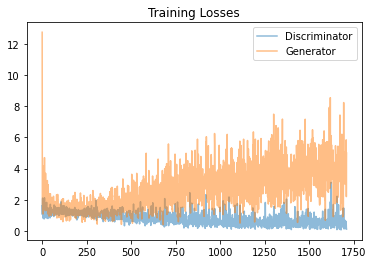

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

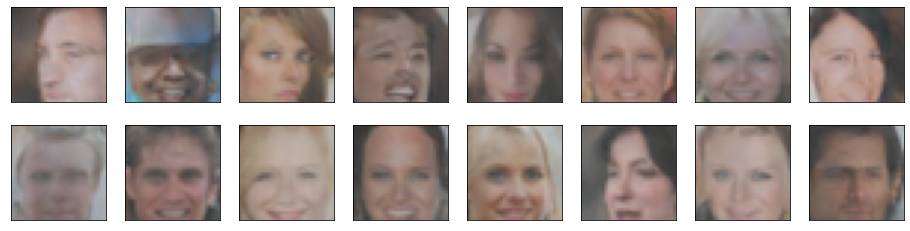

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
- It seems that the low resolution of the images made easier the generator's job, acheiving a reasonable performance with a low number of training epochs.
- For a human discriminator, some faces are quite convincing, although most of them can be easily classified as fake.
- Indeed, the CelebA dataset is widely biased with white faces, leading to the generation of white (and even pale) faces that the discriminator accepts as real.
- An immediate way to acheive a higher performance would be to increase the number of training steps, paying the associated computational cost. Considering a least squares loss function ([LSGAN](https://arxiv.org/abs/1611.04076)) should lead to performance improvements.
- It would be interesting to implement deeper and more complex architectures such as [this one](https://arxiv.org/abs/1812.04948) or including attention mechanisms into the discriminator/generator as shown [here](https://github.com/shaoanlu/faceswap-GAN)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.